In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
root_dir = "/home/lwang/models/BindCraft/BindCraft_fork/IL23_BC_PMPNN"
data_fp = f"/home/lwang/models/Data_pass/IL23_BC_PMPNN-FR/traj1_final_design_stats.csv"
filters = "/home/lwang/models/BindCraft/BindCraft_fork/extra_settings/no_PB_filters.json"

data_df = pd.read_csv(data_fp)
print(data_df.shape)

with open(filters, "r") as f:
    filters_dict = json.load(f)

for k, v in filters_dict.items():
    if v.get("threshold") is not None:
        print(f"{k}: {v}")

(5974, 232)
Average_pLDDT: {'threshold': 0.8, 'higher': True}
1_pLDDT: {'threshold': 0.8, 'higher': True}
2_pLDDT: {'threshold': 0.8, 'higher': True}
Average_pTM: {'threshold': 0.55, 'higher': True}
1_pTM: {'threshold': 0.55, 'higher': True}
2_pTM: {'threshold': 0.55, 'higher': True}
Average_i_pTM: {'threshold': 0.5, 'higher': True}
1_i_pTM: {'threshold': 0.5, 'higher': True}
2_i_pTM: {'threshold': 0.5, 'higher': True}
Average_i_pAE: {'threshold': 0.35, 'higher': False}
1_i_pAE: {'threshold': 0.35, 'higher': False}
2_i_pAE: {'threshold': 0.35, 'higher': False}
Average_Binder_Energy_Score: {'threshold': 0, 'higher': False}
1_Binder_Energy_Score: {'threshold': 0, 'higher': False}
2_Binder_Energy_Score: {'threshold': 0, 'higher': False}
Average_ShapeComplementarity: {'threshold': 0.6, 'higher': True}
1_ShapeComplementarity: {'threshold': 0.55, 'higher': True}
2_ShapeComplementarity: {'threshold': 0.55, 'higher': True}
Average_dG: {'threshold': 0, 'higher': False}
1_dG: {'threshold': 0, 'h

In [3]:
def check_filters(mpnn_data, design_labels, filters):
    # check mpnn_data against labels
    mpnn_dict = {label: value for label, value in zip(design_labels, mpnn_data)}

    unmet_conditions = []

    # check filters against thresholds
    for label, conditions in filters.items():
        # special conditions for interface amino acid counts
        if label == 'Average_InterfaceAAs' or label == '1_InterfaceAAs' or label == '2_InterfaceAAs' or label == '3_InterfaceAAs' or label == '4_InterfaceAAs' or label == '5_InterfaceAAs':
            for aa, aa_conditions in conditions.items():
                if mpnn_dict.get(label) is None:
                    continue
                value = mpnn_dict.get(label).get(aa)
                if value is None or aa_conditions["threshold"] is None:
                    continue
                if aa_conditions["higher"]:
                    if value < aa_conditions["threshold"]:
                        unmet_conditions.append(f"{label}_{aa}")
                        print(f"Unmet condition: {label}_{aa}")
                else:
                    if value > aa_conditions["threshold"]:
                        unmet_conditions.append(f"{label}_{aa}")
                        print(f"Unmet condition: {label}_{aa}")
        else:
            # if no threshold, then skip
            value = mpnn_dict.get(label)
            if value is None or conditions["threshold"] is None:
                continue
            if conditions["higher"]:
                if value < conditions["threshold"]:
                    unmet_conditions.append(label)
            else:
                if value > conditions["threshold"]:
                    unmet_conditions.append(label)

    # if all filters are passed then return True
    if len(unmet_conditions) == 0:
        return True
    # if some filters were unmet, print them out
    else:
        return unmet_conditions

In [4]:
keep_rows = []
for i, row in data_df.iterrows():
    mask = check_filters(row.to_dict(), data_df.columns, filters_dict)
    if mask:
        keep_rows.append(row)
filtered_design = pd.DataFrame(keep_rows)
print(filtered_design.shape)

TypeError: '<' not supported between instances of 'str' and 'float'

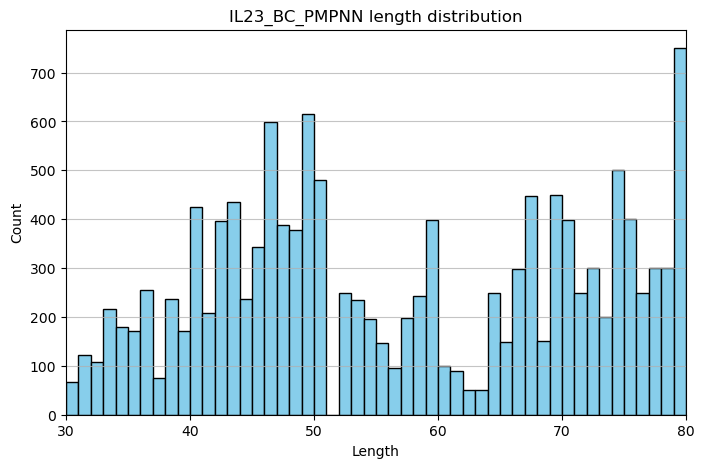

In [6]:
# binder sequence length analysis
binder_lengths = data_df["Length"]

# binder sequence length distribution
plt.figure(figsize=(8, 5))
plt.hist(binder_lengths, bins=range(30, 81, 1), color='skyblue', edgecolor='black')
plt.title("IL23_BC_PMPNN length distribution")
plt.xlabel("Length")
plt.ylabel("Count")
plt.xlim(30, 80)
plt.grid(axis='y', alpha=0.75)
plt.show()

In [3]:
import pandas as pd
import os

In [7]:
def select_topBB_design(file_path, top_N: int = 200, pick_strategy: str = 'top', num_pick_per_batch: int = 1) -> pd.DataFrame:
    '''
    Select the top-ranked designs from the MPNN scoring results.
    Args:
        ws: Workspace object
        top_N: Number of top-ranked designs to select
        pick_strategy: Strategy to pick the representative design from each group
        num_pick_per_batch: Number of designs to pick from each group
    Returns:
        pd.DataFrame: DataFrame containing (top_N * num_pick_per_batch) designs
    '''
    BB_df = pd.read_csv(file_path)
    BB_df['Length'] = BB_df['Sequence'].apply(len)
    df['Traj']=df['Design'].apply(lambda x: x.split('_')[2])
    BB_GS_L50 = BB_df[BB_df["Length"] <= 50].groupby("Traj")["MPNN_score"].mean().reset_index()
    BB_GS_M50 = BB_df[BB_df["Length"] > 50].groupby("Traj")["MPNN_score"].mean().reset_index()
    #top_designs = BB_grouped_sorted.head(top_N)
    top_designs = pd.concat([BB_GS_L50.head(top_N//2), BB_GS_M50.head(top_N//2)])

    representative_designs = BB_df[BB_df["Design"].isin(top_designs["Traj"])]
    # For each group, pick the top-ranked entry as the representative design
    if pick_strategy == 'top':
        final_grouped_table = representative_designs.groupby("Traj").apply(
            lambda x: x.nsmallest(num_pick_per_batch, "MPNN_score")
        ).reset_index(drop=True)
    elif pick_strategy == 'random':
        final_grouped_table = representative_designs.groupby("Traj").apply(
            lambda x: x.sample(n=num_pick_per_batch, random_state=42)
        ).reset_index(drop=True)
    else:
        raise ValueError(f"Invalid pick_strategy: {pick_strategy}")
    return final_grouped_table

In [4]:
df = pd.read_csv('/home/lwang/models/BindCraft/BindCraft_fork/IL23_BC_PMPNN-FR/final_design_stats_filtered.csv')
pick_df = select_topBB_design('/home/lwang/models/BindCraft/BindCraft_fork/IL23_BC_PMPNN-FR/final_design_stats_filtered.csv')

In [5]:
# For each 'traj', select half of the entries (rounded down), then count total number of selected designs

selected_indices = []
for traj in mean_scores[:300]['traj'].unique():
    group = df[df['traj'] == traj]
    n_select = len(group) // 2
    selected_indices.extend(group.index[:n_select])

selected_df = df.loc[selected_indices]
print(f"Number of designs if half entries are selected for each traj: {len(selected_df)}")


Number of designs if half entries are selected for each traj: 2793
